# Spaceship Titanic 데이터셋
* PassengerId (승객 ID): 각 승객에 대한 고유 ID. gggg_pp 형식으로, gggg는 승객이 함께 여행 중인 그룹을 나타내며 pp는 그룹 내 번호입니다. 그룹은 종종 가족 구성원이지만 항상 그렇지는 않습니다.
* HomePlanet (출발 행성): 승객이 출발한 행성으로, 일반적으로 그들의 영구 거주지입니다.
* CryoSleep (동결 수면): 승객이 항해 기간 동안 동결 수면에 들 것인지 여부를 나타냅니다. 동결 수면 중인 승객은 자신의 객실에 제한됩니다.
* Cabin (객실): 승객이 머무는 객실 번호입니다. deck/num/side 형식으로, side는 P(왼쪽) 또는 S(오른쪽)일 수 있습니다.
* Destination (도착 행성): 승객이 하선할 행성입니다.
* Age (나이): 승객의 나이입니다.
* VIP (VIP 여부): 승객이 항해 중 특별한 VIP 서비스를 결제했는지 여부입니다.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck (부대시설 사용 금액): 승객이 Spaceship Titanic의 여러 고급 시설에서 청구한 금액입니다.
* Name (이름): 승객의 이름(성과 이름)


### 계획
* 일단 그냥 돌려보기
* 이상치 제거해보기
* 스케일링 해보기
* 오버샘플링 기법 해보기
* 다른 모델 돌려보기




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install catboost
!pip install optuna

In [3]:
titanic_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/8. 머신러닝과 딥러닝/240101 과제/space/test.csv')
titanic_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/8. 머신러닝과 딥러닝/240101 과제/space/train.csv')

In [4]:
# 필요없는 열 제거
titanic_train.drop(['Name'],axis=1, inplace=True)

In [5]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 823.6+ KB


In [6]:
titanic_train.isna().mean().sort_values(ascending=False)

CryoSleep       0.024963
ShoppingMall    0.023927
VIP             0.023352
HomePlanet      0.023122
Cabin           0.022892
VRDeck          0.021627
FoodCourt       0.021051
Spa             0.021051
Destination     0.020936
RoomService     0.020821
Age             0.020591
PassengerId     0.000000
Transported     0.000000
dtype: float64

<Axes: xlabel='CryoSleep', ylabel='Transported'>

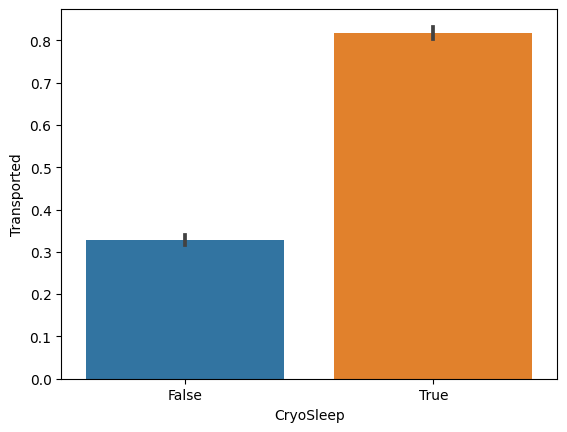

In [7]:
sns.barplot(x='CryoSleep', y = 'Transported',data=titanic_train)

In [8]:
titanic_train['CryoSleep'] = titanic_train['CryoSleep'].fillna('Unknown')
titanic_train['CryoSleep'].value_counts()

False      5439
True       3037
Unknown     217
Name: CryoSleep, dtype: int64

In [9]:
titanic_train.isna().mean().sort_values(ascending=False)

ShoppingMall    0.023927
VIP             0.023352
HomePlanet      0.023122
Cabin           0.022892
VRDeck          0.021627
FoodCourt       0.021051
Spa             0.021051
Destination     0.020936
RoomService     0.020821
Age             0.020591
PassengerId     0.000000
CryoSleep       0.000000
Transported     0.000000
dtype: float64

In [10]:
titanic_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


<Axes: >

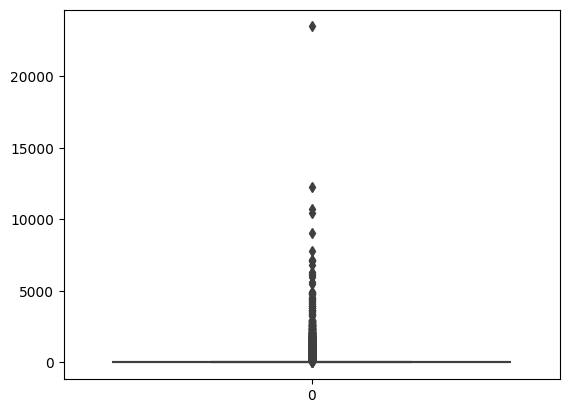

In [11]:
sns.boxplot(titanic_train['ShoppingMall'])

In [12]:
# 이상치 확인 -> 17세 쇼핑광... 이재용아들인가? 사실 소수점 2개가 틀렸다는 가정이 더 말이 되어보임 하지만 일단 놔둠
titanic_train[titanic_train['ShoppingMall'] > 20000]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
8415,8989_01,Europa,False,B/291/P,TRAPPIST-1e,17.0,False,0.0,366.0,23492.0,356.0,3.0,True


In [13]:
titanic_train[(titanic_train['ShoppingMall'] > 20000) | (titanic_train['FoodCourt'] > 20000) | (titanic_train['Spa'] > 20000) | (titanic_train['VRDeck'] > 20000)| (titanic_train['RoomService'] > 20000)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
1213,1292_01,Europa,False,B/55/S,55 Cancri e,31.0,True,0.0,27723.0,3.0,202.0,3146.0,True
1842,1969_01,Europa,False,C/75/S,55 Cancri e,27.0,False,NaN,21066.0,0.0,2448.0,2293.0,True
2067,2215_01,Europa,False,A/27/S,55 Cancri e,41.0,True,0.0,29813.0,0.0,1257.0,6.0,True
3198,3444_01,Europa,False,B/131/S,55 Cancri e,33.0,False,0.0,27071.0,0.0,15.0,0.0,True
3538,3796_01,Europa,False,B/121/P,55 Cancri e,33.0,False,90.0,26830.0,0.0,27.0,703.0,True
4311,4594_02,Europa,False,C/144/P,TRAPPIST-1e,31.0,False,0.0,6670.0,217.0,625.0,20336.0,False
5619,5977_02,Europa,False,B/230/S,55 Cancri e,57.0,False,200.0,9.0,0.0,NaN,24133.0,False
5722,6064_01,Europa,False,C/186/P,55 Cancri e,68.0,False,125.0,13437.0,0.0,22408.0,17.0,False
8415,8989_01,Europa,False,B/291/P,TRAPPIST-1e,17.0,False,0.0,366.0,23492.0,356.0,3.0,True


In [14]:
# 표준편차가 크고 cost에 관련한 변수들은 중앙값으로 대체
# 각 cost에 관련된 변수들의 중앙값 계산
median_values = titanic_train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].median()

# 중앙값으로 대체
titanic_train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = titanic_train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(median_values)

In [15]:
titanic_train.isna().mean().sort_values(ascending=False)

VIP             0.023352
HomePlanet      0.023122
Cabin           0.022892
Destination     0.020936
Age             0.020591
PassengerId     0.000000
CryoSleep       0.000000
RoomService     0.000000
FoodCourt       0.000000
ShoppingMall    0.000000
Spa             0.000000
VRDeck          0.000000
Transported     0.000000
dtype: float64

<Axes: xlabel='HomePlanet', ylabel='Transported'>

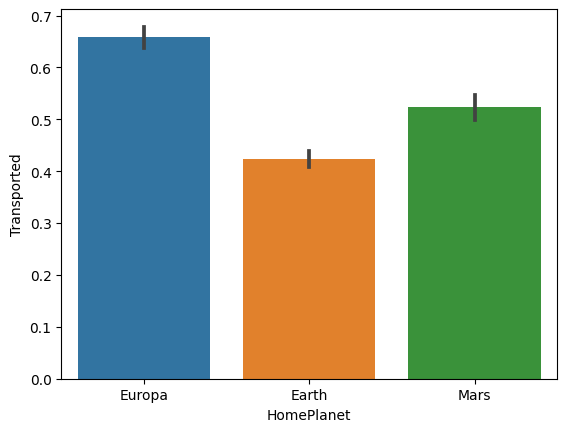

In [16]:
sns.barplot(x='HomePlanet', y = 'Transported',data=titanic_train)

In [17]:
titanic_train['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [18]:
titanic_train['HomePlanet'].isnull().sum()

201

In [19]:
titanic_train['HomePlanet'].fillna('Unknown', inplace=True)

<Axes: xlabel='VIP', ylabel='Transported'>

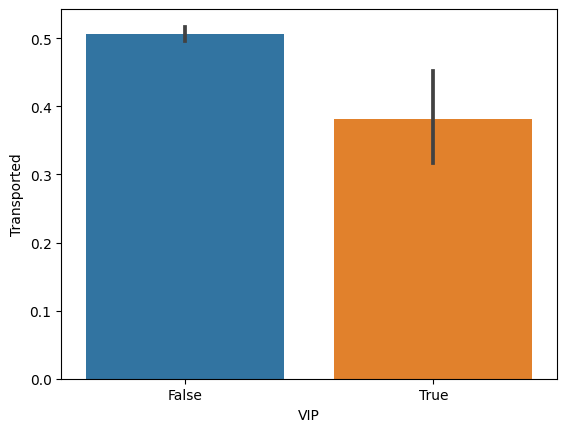

In [20]:
sns.barplot(x='VIP', y = 'Transported',data=titanic_train)

In [21]:
titanic_train['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: int64

In [22]:
# vip는 True, False로 이루어진 값임으로 결측치를 변경
titanic_train['VIP'] = titanic_train['VIP'].fillna('Unknown')

In [23]:
# Age가 NaN인 애들 평균으로 변경
age_mean = titanic_train['Age'].mean()
titanic_train['Age'] = titanic_train['Age'].fillna(age_mean)

In [24]:
titanic_train.isna().mean().sort_values(ascending=False)

Cabin           0.022892
Destination     0.020936
PassengerId     0.000000
HomePlanet      0.000000
CryoSleep       0.000000
Age             0.000000
VIP             0.000000
RoomService     0.000000
FoodCourt       0.000000
ShoppingMall    0.000000
Spa             0.000000
VRDeck          0.000000
Transported     0.000000
dtype: float64

In [25]:
# Cabin은 deck/num/side 형식으로, side는 P(왼쪽) 또는 S(오른쪽)으로 이루어진 데이터임으로 NaN값 삭제하고싶지만 예측에 중요할듯하니 살려둬
titanic_train['Cabin'].value_counts()

G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

In [26]:
# titanic_train = titanic_train.dropna(subset=['Cabin'])
titanic_train['Cabin'] = titanic_train['Cabin'].fillna('Unknown/Unknown/Unknown')

In [27]:
titanic_train['Destination'].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [28]:
titanic_train['Destination'].fillna('Unknown', inplace = True)

In [29]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   object 
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 823.6+ KB


# 3. 데이터 정제

In [30]:
# PassengerId (승객 ID): 각 승객에 대한 고유 ID. gggg_pp 형식으로, gggg는 승객이 함께 여행 중인 그룹을 나타내며 pp는 그룹 내 번호입니다. 그룹은 종종 가족 구성원이지만 항상 그렇지는 않습니다
titanic_train['PassengerId']

0       0001_01
1       0002_01
2       0003_01
3       0003_02
4       0004_01
         ...   
8688    9276_01
8689    9278_01
8690    9279_01
8691    9280_01
8692    9280_02
Name: PassengerId, Length: 8693, dtype: object

In [31]:
titanic_train['GroupNum'] = pd.to_numeric(titanic_train['PassengerId'].str.split('_').str[0])
titanic_train['GroupNum'].value_counts()

4498    8
8168    8
8728    8
8796    8
8956    8
       ..
3483    1
3480    1
3478    1
3473    1
4620    1
Name: GroupNum, Length: 6217, dtype: int64

In [32]:
titanic_train['GroupNumCnt'] = titanic_train['PassengerId'].str.split('_').str[0].map(titanic_train['PassengerId'].str.split('_').str[0].value_counts())
titanic_train = titanic_train.drop('PassengerId',axis=1)
titanic_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNum,GroupNumCnt
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,1
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,1
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,2
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,2
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,1


In [33]:
# Cabin은 deck/num/side 형식으로, side는 P(왼쪽) 또는 S(오른쪽)으로 이루어진 데이터
# Cabin의 데이터 쪼개서 각각의 변수로 저장
titanic_train['deck'] = titanic_train['Cabin'].apply(lambda x : x.split('/')[0])
titanic_train['roomNum'] = pd.to_numeric(titanic_train['Cabin'].apply(lambda x : 0 if x.split('/')[1] == 'Unknown' else x.split('/')[1]))
titanic_train['side'] = titanic_train['Cabin'].apply(lambda x : x.split('/')[2])
titanic_train = titanic_train.drop('Cabin',axis=1)
titanic_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNum,GroupNumCnt,deck,roomNum,side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,1,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,1,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,2,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,2,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,1,F,1,S


In [34]:
titanic_train['roomNum'].value_counts()

0       217
82       28
86       22
19       22
56       21
       ... 
1644      1
1515      1
1639      1
1277      1
1894      1
Name: roomNum, Length: 1817, dtype: int64

In [35]:
titanic_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNum,GroupNumCnt,deck,roomNum,side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,1,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,1,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,2,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,2,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,1,F,1,S


In [36]:
titanic_train.select_dtypes('object').columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'deck', 'side'], dtype='object')

In [37]:
titanic_train = pd.get_dummies(titanic_train,columns= titanic_train.select_dtypes('object').columns)
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        8693 non-null   float64
 1   RoomService                8693 non-null   float64
 2   FoodCourt                  8693 non-null   float64
 3   ShoppingMall               8693 non-null   float64
 4   Spa                        8693 non-null   float64
 5   VRDeck                     8693 non-null   float64
 6   Transported                8693 non-null   bool   
 7   GroupNum                   8693 non-null   int64  
 8   GroupNumCnt                8693 non-null   int64  
 9   roomNum                    8693 non-null   int64  
 10  HomePlanet_Earth           8693 non-null   uint8  
 11  HomePlanet_Europa          8693 non-null   uint8  
 12  HomePlanet_Mars            8693 non-null   uint8  
 13  HomePlanet_Unknown         8693 non-null   uint8

# 4. 모델돌리기

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(titanic_train.drop('Transported',axis=1), titanic_train['Transported'], test_size = 0.2, random_state = 2023)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

### 4.1. 기본

* 'Linear Regression': 0.7768832662449684,
*  'Decision Tree': 0.7550316273720529,
*  'Random Forest': 0.8016101207590569,
*  'Support Vector Machine': 0.7832087406555491,
*  'Light Gradient Boosting': 0.8056354226566993

LGBM이 0.8056354226566993로 제일 좋은 결과

In [41]:
X_train, X_test, y_train, y_test = train_test_split(titanic_train.drop('Transported',axis=1), titanic_train['Transported'], test_size = 0.2, random_state = 2023)
all_results = []
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
models = {
    "Linear Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Light Gradient Boosting": LGBMClassifier()
}
# Train and evaluate the models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    roc_score = accuracy_score(y_test, predictions)
    results[name] = roc_score
all_results.append(results)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3487, number of negative: 3467
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1923
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005752
[LightGBM] [Info] Start training from score 0.005752


### 4.2. GroupNum 삭제시
* 'Linear Regression': 0.7850525015441631,
*  'Decision Tree': 0.7374922791846819,
*  'Random Forest': 0.7992588017294626,
*  'Support Vector Machine': 0.781964175416924,
*  'Light Gradient Boosting': 0.8054354539839407

In [42]:
X_train, X_test, y_train, y_test = train_test_split(titanic_train.drop(['Transported','GroupNum'],axis=1), titanic_train['Transported'], test_size = 0.2, random_state = 2023)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
models = {
    "Linear Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Light Gradient Boosting": LGBMClassifier()
}
# Train and evaluate the models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    roc_score = roc_auc_score(y_test, predictions)
    results[name] = roc_score
all_results.append(results)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3487, number of negative: 3467
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005752
[LightGBM] [Info] Start training from score 0.005752


### 4.3. GroupNum과 roomNum 둘다 삭제시
* 'Linear Regression': 0.7850525015441631,
*  'Decision Tree': 0.7374922791846819,
*  'Random Forest': 0.7992588017294626,
*  'Support Vector Machine': 0.781964175416924,
*  'Light Gradient Boosting': 0.8054354539839407



In [43]:
X_train, X_test, y_train, y_test = train_test_split(titanic_train.drop(['Transported','GroupNum','roomNum'],axis=1), titanic_train['Transported'], test_size = 0.2, random_state = 2023)
models = {
    "Linear Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Light Gradient Boosting": LGBMClassifier()
}
# Train and evaluate the models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    roc_score = roc_auc_score(y_test, predictions)
    results[name] = roc_score
all_results.append(results)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3487, number of negative: 3467
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1413
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005752
[LightGBM] [Info] Start training from score 0.005752


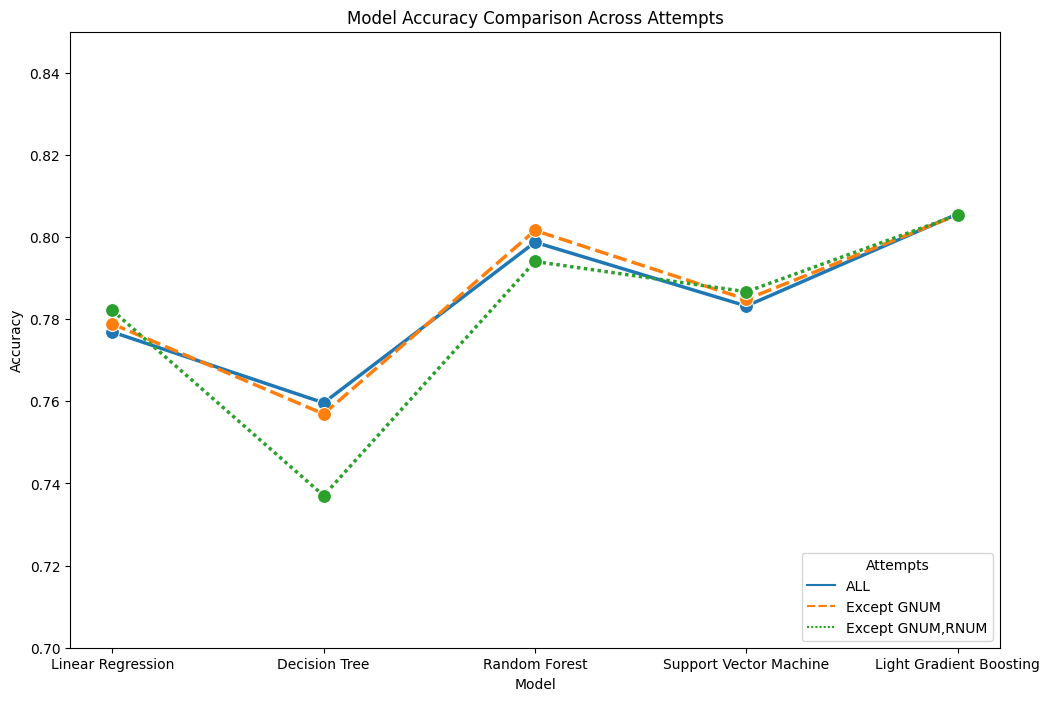

In [44]:
# 점그래프 그리기
df_results = pd.DataFrame(all_results)
df_results.index = ['ALL', 'Except GNUM', 'Except GNUM,RNUM']
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_results.T, marker="o", markersize=10, linewidth=2.5)
plt.title("Model Accuracy Comparison Across Attempts")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.legend(title="Attempts", loc="lower right")
plt.ylim(0.7, 0.85)  # y축 범위를 0~1로 설정 (정확도의 범위)
plt.show()

# 5. 스케일링

In [45]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

### 5.1. MinMaxScaler

In [46]:
scaler_mm = MinMaxScaler()
X = titanic_train.drop(['Transported','GroupNum'],axis=1)
y = titanic_train['Transported']
# 독립 변수 정규화
Xmm = scaler_mm.fit_transform(X)

In [47]:
X_train, X_test , y_train, y_test = train_test_split(Xmm,y,test_size=0.2,random_state=2023)

In [48]:
models = {
    "Linear Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Light Gradient Boosting": LGBMClassifier()
}
# Train and evaluate the models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    roc_score = roc_auc_score(y_test, predictions)
    results[name] = roc_score
all_results.append(results)
results

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 3487, number of negative: 3467
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1667
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005752
[LightGBM] [Info] Start training from score 0.005752


{'Linear Regression': 0.7551821940579803,
 'Decision Tree': 0.7450573608199395,
 'Random Forest': 0.7970010641001207,
 'Support Vector Machine': 0.7391723842195541,
 'Light Gradient Boosting': 0.8054390868856278}

### 5.2. StandardScaler

In [49]:
scaler_ss = StandardScaler()
X = titanic_train.drop(['Transported','GroupNum','roomNum'],axis=1)
y = titanic_train['Transported']
# 독립 변수 정규화
Xss = scaler_ss.fit_transform(X)
X_train, X_test , y_train, y_test = train_test_split(Xss,y,test_size=0.2,random_state=2023)

In [50]:
models = {
    "Linear Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Light Gradient Boosting": LGBMClassifier()
}
# Train and evaluate the models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    roc_score = roc_auc_score(y_test, predictions)
    results[name] = roc_score
all_results.append(results)
results

[LightGBM] [Info] Number of positive: 3487, number of negative: 3467
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005752
[LightGBM] [Info] Start training from score 0.005752


{'Linear Regression': 0.7821307943163289,
 'Decision Tree': 0.7409869131567245,
 'Random Forest': 0.7906290366982192,
 'Support Vector Machine': 0.78607484700252,
 'Light Gradient Boosting': 0.797347161340872}

### 5.3. RobustScaler



In [51]:
scaler_rb = RobustScaler()
X = titanic_train.drop(['Transported','GroupNum','roomNum'],axis=1)
y = titanic_train['Transported']
# 독립 변수 정규화
Xrb = scaler_rb.fit_transform(X)
X_train, X_test , y_train, y_test = train_test_split(Xrb,y,test_size=0.2,random_state=2023)

In [52]:
models = {
    "Linear Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Light Gradient Boosting": LGBMClassifier()
}
# Train and evaluate the models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    roc_score = roc_auc_score(y_test, predictions)
    results[name] = roc_score
all_results.append(results)
results

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 3487, number of negative: 3467
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1412
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501438 -> initscore=0.005752
[LightGBM] [Info] Start training from score 0.005752


{'Linear Regression': 0.7837573851724795,
 'Decision Tree': 0.7462935169303094,
 'Random Forest': 0.8002827012260975,
 'Support Vector Machine': 0.7913986563750716,
 'Light Gradient Boosting': 0.8054026904262754}

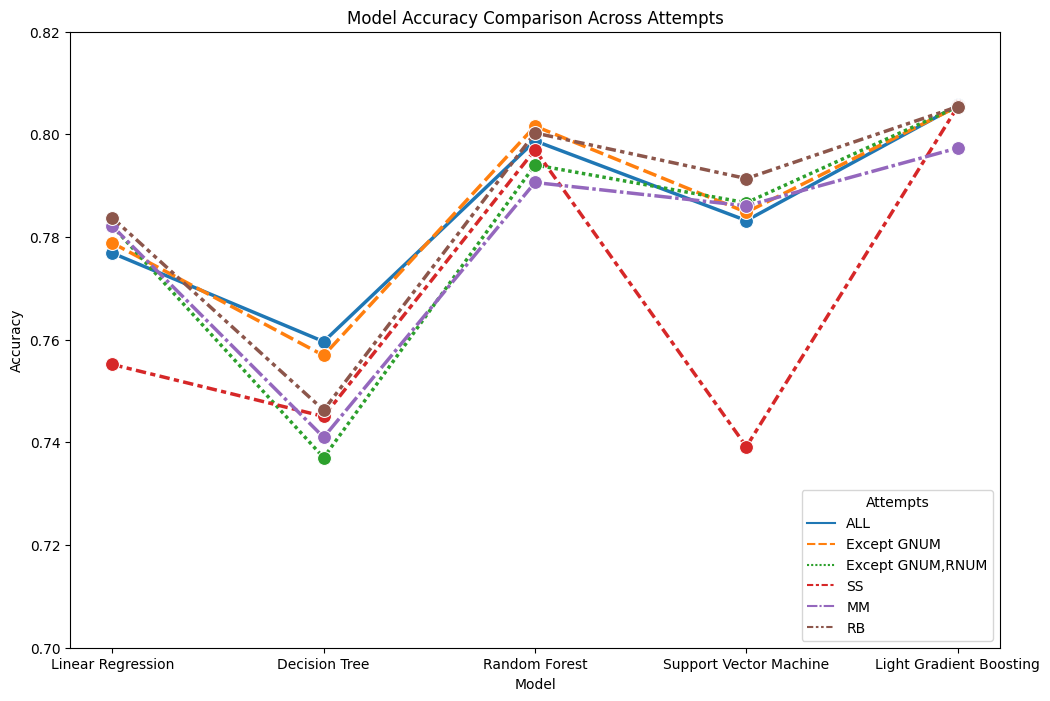

In [54]:
# 점그래프 그리기
df_results = pd.DataFrame(all_results)
df_results.index = ['ALL', 'Except GNUM', 'Except GNUM,RNUM','SS','MM','RB']
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_results.T, marker="o", markersize=10, linewidth=2.5)
plt.title("Model Accuracy Comparison Across Attempts")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.legend(title="Attempts", loc="lower right")
plt.ylim(0.7, 0.82)  # y축 범위를 0~1로 설정 (정확도의 범위)
plt.show()

6. 하이퍼 파라미터 튜닝

In [56]:
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2023)
from sklearn.model_selection import GridSearchCV
models = {
    "Light Gradient Boosting": LGBMClassifier()
}
# Define hyperparameter grids for each model
param_grid_lgbm = {'learning_rate': [0.001, 0.01, 0.1],
                   'n_estimators': [50, 100, 200]}

# Define hyperparameter grid dictionary
param_grids = {
    "Light Gradient Boosting": param_grid_lgbm
}

# Train and evaluate the models with hyperparameter tuning
results_tuned = {}

for name, model in models.items():
    param_grid = param_grids[name]
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    # Train the model with the best hyperparameters
    tuned_model = model.set_params(**best_params)
    tuned_model.fit(X_train, y_train)

    # Evaluate the tuned model
    predictions_tuned = tuned_model.predict(X_test)
    roc_score_tuned = roc_auc_score(y_test, predictions_tuned)

    results_tuned[name] = {'Best_Params': best_params, 'ROC_AUC_Score': roc_score_tuned}

results_tuned

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2790, number of negative: 2773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1413
[LightGBM] [Info] Number of data points in the train set: 5563, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501528 -> initscore=0.006112
[LightGBM] [Info] Start training from score 0.006112
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2790, number of negative: 2773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

{'Light Gradient Boosting': {'Best_Params': {'learning_rate': 0.1,
   'n_estimators': 50},
  'ROC_AUC_Score': 0.8058215805857316}}

# 7. XGBoost 활용

In [57]:
import xgboost as xgb

In [58]:
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
roc_score = roc_auc_score(y_test, predictions)
print(roc_score)

0.8054026904262754


# 8. 교차검증 활용

In [59]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer

# Define models
models = {
    "Linear Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Light Gradient Boosting": LGBMClassifier()
}

# Define a function to perform k-fold cross-validation and return the mean ROC AUC score
def evaluate_model(model, X, y, k=5):
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    roc_auc_scorer = make_scorer(roc_auc_score)
    scores = cross_val_score(model, X, y, cv=cv, scoring=roc_auc_scorer)
    return scores.mean()

# Train and evaluate the models using k-fold cross-validation
results_kfold = {}

for name, model in models.items():
    roc_auc_mean = evaluate_model(model, X_train, y_train)
    results_kfold[name] = roc_auc_mean

# Display results
for name, roc_auc_mean in results_kfold.items():
    print(f"{name}: Mean ROC AUC - {roc_auc_mean}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2790, number of negative: 2773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1412
[LightGBM] [Info] Number of data points in the train set: 5563, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501528 -> initscore=0.006112
[LightGBM] [Info] Start training from score 0.006112
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2790, number of negative: 2773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

# CatBoost

* 부스팅(Boosting) 알고리즘:
CatBoost는 부스팅 알고리즘 중 하나입니다. 부스팅은 여러 개의 약한 학습자(weak learner)를 조합하여 강한 학습자(strong learner)를 만드는 기법입니다. CatBoost는 특히 Gradient Boosting의 변형 중 하나로, 트리 기반 모델을 사용합니다.

* Level-wise 트리 확장:
CatBoost는 트리를 level-wise 방식으로 확장합니다. 트리의 각 레벨을 한 번에 확장하여 모든 리프 노드가 동일한 깊이를 갖게 합니다. 이는 과적합을 예방하며 깊이 제한을 통해 안정적인 모델을 형성합니다.

    * Level-wise와 Leaf-wise 비교:
        * Level-wise는 각 레벨을 순차적으로 확장하며, 전체 트리를 균일하게 확장합니다.
        * Leaf-wise는 가장 큰 잔차를 갖는 노드를 선택하여 해당 노드만 확장합니다. 빠른 학습을 가능케 하지만, 과적합에 민감할 수 있습니다.

* Ordered-Boosting 방식:
CatBoost는 Ordered-Boosting 방식을 사용하여 학습 데이터의 순서를 중요하게 고려합니다. 이 방식에서는 전체 데이터셋 대신 일부 데이터를 선택하여 훈련하고 결과를 기반으로 모델을 업데이트합니다. 데이터의 순서는 무작위로 섞이며, 이는 다양한 측면에서 학습되어 오버피팅을 방지하고 일반화 성능을 향상시킵니다.

* 범주형 변수 처리 방법:
CatBoost는 범주형 변수를 효과적으로 처리합니다. Response Encoding과 Categorical Feature Combination을 사용하여 범주형 변수의 정보를 효율적으로 활용합니다.

* 자동 특성 스케일링:
CatBoost는 특성 간의 크기 차이에 민감하지 않아, 사용자가 전처리에 신경쓸 필요가 없습니다.

* 자동 튜닝 및 빠른 학습:
CatBoost는 기본 설정에서도 좋은 성능을 보이며, 내부적으로 효율적인 구현을 통해 빠른 학습 속도를 제공합니다. 수동 튜닝이 적게 필요합니다.

* 범주형 변수의 Label Ordering 활용:
CatBoost는 범주형 변수의 라벨 순서를 활용하여 모델의 학습을 최적화합니다. 범주형 변수의 순서가 중요한 경우 성능을 향상시킬 수 있습니다.


https://julie-tech.tistory.com/119

In [82]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score

# CatBoost 데이터 포맷으로 변환
train_pool = Pool(data=X_train, label=y_train)  # cat_features에 범주형 특성의 인덱스를 지정

# CatBoost 모델 생성 및 학습
model = CatBoostClassifier()
# iterations (트리 개수):

# 설명: Boosting 라운드 수 또는 트리의 개수를 나타냅니다.
# 값: 양의 정수. 높은 값은 더 강력한 모델을 생성하지만 과적합의 위험이 있습니다.
# depth (트리 깊이):

# 설명: 각 트리의 최대 깊이를 나타냅니다.
# 값: 양의 정수. 깊은 트리는 더 복잡한 패턴을 학습할 수 있지만, 과적합의 위험이 있습니다.
# learning_rate (학습률):

# 설명: 각 트리의 예측에 대한 영향을 줄이는 비율입니다.
# 값: 0에서 1 사이의 실수. 작은 값은 모델을 더 안정적으로 만들 수 있습니다.
# loss_function (손실 함수):

# 설명: 최적화할 손실 함수를 선택합니다. 'Logloss'는 로지스틱 손실 함수를 나타냅니다.
# 값: 'Logloss' 또는 기타 손실 함수 옵션.
model.fit(train_pool)

# 테스트 데이터에 대한 예측 및 평가
test_pool = Pool(data=X_test)
y_pred_proba = model.predict_proba(test_pool)[:, 1]
roc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_score}")


Learning rate set to 0.023581
0:	learn: 0.6814063	total: 13.4ms	remaining: 13.4s
1:	learn: 0.6702728	total: 24.1ms	remaining: 12s
2:	learn: 0.6606777	total: 33.7ms	remaining: 11.2s
3:	learn: 0.6493467	total: 44.2ms	remaining: 11s
4:	learn: 0.6402262	total: 54.7ms	remaining: 10.9s
5:	learn: 0.6311658	total: 66.1ms	remaining: 11s
6:	learn: 0.6226764	total: 77.3ms	remaining: 11s
7:	learn: 0.6136268	total: 91ms	remaining: 11.3s
8:	learn: 0.6068946	total: 102ms	remaining: 11.2s
9:	learn: 0.6005306	total: 112ms	remaining: 11.1s
10:	learn: 0.5939807	total: 122ms	remaining: 10.9s
11:	learn: 0.5876051	total: 132ms	remaining: 10.9s
12:	learn: 0.5818801	total: 148ms	remaining: 11.2s
13:	learn: 0.5747835	total: 158ms	remaining: 11.1s
14:	learn: 0.5691806	total: 172ms	remaining: 11.3s
15:	learn: 0.5635365	total: 178ms	remaining: 10.9s
16:	learn: 0.5589446	total: 182ms	remaining: 10.5s
17:	learn: 0.5544511	total: 190ms	remaining: 10.4s
18:	learn: 0.5500275	total: 196ms	remaining: 10.1s
19:	learn: 0.

In [83]:
import optuna
from optuna.samplers import TPESampler
import catboost

def objective(trial):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred_proba)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=10)

trial = study.best_trial
print("Best Trial AUC-ROC Score:", trial.value)
print("Best Params:", trial.params.items())

model = catboost.CatBoostClassifier(**trial.params, verbose=False)
model.fit(X_train, y_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

train_auc_roc_score = roc_auc_score(y_train, y_train_pred_proba)
test_auc_roc_score = roc_auc_score(y_test, y_test_pred_proba)

print("Train AUC-ROC Score:", train_auc_roc_score)
print("Test AUC-ROC Score:", test_auc_roc_score)

[I 2024-01-04 12:24:02,285] A new study created in memory with name: catboost
[I 2024-01-04 12:24:04,162] Trial 0 finished with value: 0.8877380990195456 and parameters: {'iterations': 475, 'learning_rate': 0.027583475549166746, 'depth': 4, 'l2_leaf_reg': 1.0551779964424746e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 2.0931628460945333e-07, 'bagging_temperature': 0.923385947687978, 'od_type': 'Iter', 'od_wait': 26}. Best is trial 0 with value: 0.8877380990195456.
[I 2024-01-04 12:24:09,187] Trial 1 finished with value: 0.8843552135611884 and parameters: {'iterations': 585, 'learning_rate': 0.006892694481137703, 'depth': 8, 'l2_leaf_reg': 1.10795595820296e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 0.7999391045172093, 'bagging_temperature': 0.27387593197926163, 'od_type': 'IncToDec', 'od_wait': 32}. Best is trial 0 with value: 0.8877380990195456.
[I 2024-01-04 12:24:12,399] Trial 2 finished with value: 0.8529139667111366 and parameters: {'iterations': 226, 'learning_

Best Trial AUC-ROC Score: 0.8877380990195456
Best Params: dict_items([('iterations', 475), ('learning_rate', 0.027583475549166746), ('depth', 4), ('l2_leaf_reg', 1.0551779964424746e-05), ('bootstrap_type', 'Bayesian'), ('random_strength', 2.0931628460945333e-07), ('bagging_temperature', 0.923385947687978), ('od_type', 'Iter'), ('od_wait', 26)])
Train AUC-ROC Score: 0.9176404030330961
Test AUC-ROC Score: 0.8877380990195456


In [84]:
import catboost
from catboost import Pool
from sklearn.metrics import roc_auc_score

# Assuming X_train, y_train, X_test, y_test are defined somewhere before this code

# Convert training data to catboost.Pool
train_pool = Pool(X_train, label=y_train)

best_params = dict(trial.params)

final_model = catboost.CatBoostClassifier(**best_params, verbose=False)
final_model.fit(train_pool)

# Evaluate on the test set
y_test_pred_proba = final_model.predict_proba(X_test)[:, 1]
test_auc_roc_score = roc_auc_score(y_test, y_test_pred_proba)
print("Test AUC-ROC Score with Final Model:", test_auc_roc_score)

# Get feature importance
feature_importance = final_model.get_feature_importance(data=train_pool,
                                                        type='LossFunctionChange',
                                                        prettified=False,
                                                        thread_count=-1,
                                                        verbose=False)

# Create a dictionary to store feature names and their importance
feature_importance_dict = {feature: importance for feature, importance in zip(X_train.columns, feature_importance)}

# Sort the dictionary by importance in ascending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1],reverse = True)

# Print or use the sorted feature importance as needed
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Test AUC-ROC Score with Final Model: 0.8877380990195456
Spa: 0.060539934881883306
VRDeck: 0.049170683349803124
RoomService: 0.030468477617197898
FoodCourt: 0.02336735458583472
CryoSleep_True: 0.011324515725402107
ShoppingMall: 0.009813838424517718
Age: 0.009505963136368367
HomePlanet_Earth: 0.008388223204215783
deck_E: 0.006254300908188737
side_S: 0.005407864485622527
HomePlanet_Europa: 0.005266468563206228
CryoSleep_False: 0.005113393784942466
deck_G: 0.002997508044541297
HomePlanet_Mars: 0.002259497054315107
deck_C: 0.0021899334428227557
Destination_TRAPPIST-1e: 0.0016597948949022001
Destination_55 Cancri e: 0.001463261390598769
GroupNumCnt: 0.0012621190397859583
deck_F: 0.0009915848251532133
side_P: 0.000977328926662857
Destination_PSO J318.5-22: 0.0006840467818577389
deck_A: 0.0006624138043775374
HomePlanet_Unknown: 0.0005383513960543485
VIP_Unknown: 0.0002498050081383707
deck_B: 0.00018941034460812078
side_Unknown: 0.00012659477810195163
deck_D: 0.00011507111019909422
Destination_

# 10. test 전처리

In [85]:
titanic_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/8. 머신러닝과 딥러닝/240101 과제/space/test.csv')
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [86]:
titanic_test.drop(['Name'],axis=1, inplace=True)
# NA값 Unknown으로 대체
titanic_test['CryoSleep'] = titanic_test['CryoSleep'].fillna('Unknown')
# cost에 관련한 변수들은 중앙값으로 대체
# 기존의 중앙값으로 대체
titanic_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = titanic_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(median_values)
# NA값 Unknown으로 대체
titanic_test['HomePlanet'].fillna('Unknown', inplace=True)
# vip는 True, False로 이루어진 값임으로 결측치를 변경
titanic_test['VIP'] = titanic_test['VIP'].fillna('Unknown')
# Age가 NaN인 애들 평균으로 변경
titanic_test['Age'] = titanic_test['Age'].fillna(age_mean)
# Cabin은 deck/num/side 형식으로, side는 P(왼쪽) 또는 S(오른쪽)으로 이루어진 데이터임으로 NaN값 삭제하고싶지만 예측에 중요할듯하니 살려둬
# titanic_train = titanic_train.dropna(subset=['Cabin'])
titanic_test['Cabin'] = titanic_test['Cabin'].fillna('Unknown/Unknown/Unknown')
# NA값 Unknown으로 대체
titanic_test['Destination'].fillna('Unknown', inplace = True)
# titanic_train['GroupNum'] = pd.to_numeric(titanic_train['PassengerId'].str.split('_').str[0])
titanic_test['GroupNumCnt'] = titanic_test['PassengerId'].str.split('_').str[0].map(titanic_test['PassengerId'].str.split('_').str[0].value_counts())
titanic_test = titanic_test.drop('PassengerId',axis=1)
# Cabin은 deck/num/side 형식으로, side는 P(왼쪽) 또는 S(오른쪽)으로 이루어진 데이터
# Cabin의 데이터 쪼개서 각각의 변수로 저장
titanic_test['deck'] = titanic_test['Cabin'].apply(lambda x : x.split('/')[0])
titanic_test['roomNum'] = pd.to_numeric(titanic_test['Cabin'].apply(lambda x : 0 if x.split('/')[1] == 'Unknown' else x.split('/')[1]))
titanic_test['side'] = titanic_test['Cabin'].apply(lambda x : x.split('/')[2])
titanic_test = titanic_test.drop('Cabin',axis=1)

In [87]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4277 non-null   object 
 1   CryoSleep     4277 non-null   object 
 2   Destination   4277 non-null   object 
 3   Age           4277 non-null   float64
 4   VIP           4277 non-null   object 
 5   RoomService   4277 non-null   float64
 6   FoodCourt     4277 non-null   float64
 7   ShoppingMall  4277 non-null   float64
 8   Spa           4277 non-null   float64
 9   VRDeck        4277 non-null   float64
 10  GroupNumCnt   4277 non-null   int64  
 11  deck          4277 non-null   object 
 12  roomNum       4277 non-null   int64  
 13  side          4277 non-null   object 
dtypes: float64(6), int64(2), object(6)
memory usage: 467.9+ KB


In [88]:
titanic_test = pd.get_dummies(titanic_test,columns= titanic_test.select_dtypes('object').columns)
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        4277 non-null   float64
 1   RoomService                4277 non-null   float64
 2   FoodCourt                  4277 non-null   float64
 3   ShoppingMall               4277 non-null   float64
 4   Spa                        4277 non-null   float64
 5   VRDeck                     4277 non-null   float64
 6   GroupNumCnt                4277 non-null   int64  
 7   roomNum                    4277 non-null   int64  
 8   HomePlanet_Earth           4277 non-null   uint8  
 9   HomePlanet_Europa          4277 non-null   uint8  
 10  HomePlanet_Mars            4277 non-null   uint8  
 11  HomePlanet_Unknown         4277 non-null   uint8  
 12  CryoSleep_False            4277 non-null   uint8  
 13  CryoSleep_True             4277 non-null   uint8

In [93]:
import catboost
from sklearn.metrics import roc_auc_score

# Assuming X_train, y_train, X_test, y_test are defined somewhere before this code

final_model = catboost.CatBoostClassifier(verbose=0)
final_model.fit(X_train, y_train)

y_train_pred_proba = final_model.predict_proba(X_train)[:, 1]
y_test_pred_proba = final_model.predict_proba(X_test)[:, 1]

train_auc_roc_score = roc_auc_score(y_train, y_train_pred_proba)
test_auc_roc_score = roc_auc_score(y_test, y_test_pred_proba)

print("Train AUC-ROC Score:", train_auc_roc_score)
print("Test AUC-ROC Score:", test_auc_roc_score)

Train AUC-ROC Score: 0.9463004414848708
Test AUC-ROC Score: 0.8894447620862715


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
X_train, X_test, y_train, y_test = train_test_split(titanic_train2.drop(['Transported'],axis=1), titanic_train2['Transported'], test_size = 0.20, random_state = 42)

import optuna
from optuna.samplers import TPESampler
import catboost

def objective(trial):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred_proba)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

trial = study.best_trial
print("Best Trial AUC-ROC Score:", trial.value)
print("Best Params:", trial.params.items())

model = catboost.CatBoostClassifier(**trial.params, verbose=False)
model.fit(X_train, y_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

train_auc_roc_score = roc_auc_score(y_train, y_train_pred_proba)
test_auc_roc_score = roc_auc_score(y_test, y_test_pred_proba)

print("Train AUC-ROC Score:", train_auc_roc_score)
print("Test AUC-ROC Score:", test_auc_roc_score)

[I 2024-01-02 05:56:05,589] A new study created in memory with name: catboost
[I 2024-01-02 05:56:08,782] Trial 0 finished with value: 0.8896023324047103 and parameters: {'iterations': 475, 'learning_rate': 0.027583475549166746, 'depth': 4, 'l2_leaf_reg': 1.0551779964424746e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 2.0931628460945333e-07, 'bagging_temperature': 0.923385947687978, 'od_type': 'Iter', 'od_wait': 26}. Best is trial 0 with value: 0.8896023324047103.
[I 2024-01-02 05:56:16,742] Trial 1 finished with value: 0.8845987475494671 and parameters: {'iterations': 585, 'learning_rate': 0.006892694481137703, 'depth': 8, 'l2_leaf_reg': 1.10795595820296e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 0.7999391045172093, 'bagging_temperature': 0.27387593197926163, 'od_type': 'IncToDec', 'od_wait': 32}. Best is trial 0 with value: 0.8896023324047103.
[I 2024-01-02 05:56:20,255] Trial 2 finished with value: 0.8520248479412876 and parameters: {'iterations': 226, 'learning_

Best Trial AUC-ROC Score: 0.8921785337280642
Best Params: dict_items([('iterations', 777), ('learning_rate', 0.058705917001944524), ('depth', 4), ('l2_leaf_reg', 16.916475058503668), ('bootstrap_type', 'Bayesian'), ('random_strength', 0.00016860534392103431), ('bagging_temperature', 0.2593171492290443), ('od_type', 'Iter'), ('od_wait', 22)])
Train AUC-ROC Score: 0.9387965092232609
Test AUC-ROC Score: 0.8921785337280642


In [ ]:
import catboost
from sklearn.metrics import roc_auc_score

# Assuming X_train, y_train, X_test, y_test are defined somewhere before this code

best_params = {
    'iterations': 389,
    'learning_rate': 0.030168335428861697,
    'depth': 4,
    'l2_leaf_reg': 4.514218461939623e-08,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.7123328961020556e-05,
    'bagging_temperature': 0.19847564831429476,
    'od_type': 'IncToDec',
    'od_wait': 12
}

final_model = catboost.CatBoostClassifier(**best_params, verbose=False)
final_model.fit(X_train, y_train)

# Get feature importance
feature_importance = final_model.get_feature_importance(data=None,
                                                        type='LossFunctionChange',
                                                        prettified=False,
                                                        thread_count=-1,
                                                        verbose=False)

# Print feature importance
print("Feature Importance:")
for feature, importance in zip(X_train.columns, feature_importance):
    print(f"{feature}: {importance}")


array(['True', 'False', 'True', ..., 'True', 'True', 'True'], dtype=object)

In [ ]:
titanic_test_reload = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/8. 머신러닝과 딥러닝/240101 과제/space/test.csv')
result_df = pd.DataFrame({'Transported': y_test_pred, 'PassengerId':titanic_test_reload['PassengerId'] })

# Save to CSV without index
result_df.to_csv('y_test_pred_6try.csv', index=False)

# 하이퍼파라미터 추가버전 - 챗GPT
- 극심한 과적합으로 이전버전 사용

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
X_train, X_test, y_train, y_test = train_test_split(titanic_train2.drop(['Transported'],axis=1), titanic_train2['Transported'], test_size = 0.3, random_state = 42)

import optuna
from optuna.samplers import TPESampler
import catboost

def objective(trial):
    grow_policy = trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"])
    if grow_policy == "Lossguide":
        model = catboost.CatBoostClassifier(
            iterations=trial.suggest_int("iterations", 100, 1000),
            learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
            depth=trial.suggest_int("depth", 4, 10),
            l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
            bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
            random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
            bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
            od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
            od_wait=trial.suggest_int("od_wait", 10, 50),
            grow_policy=grow_policy,
            min_child_samples=trial.suggest_int("min_child_samples", 1, 20),
            max_leaves=trial.suggest_int("max_leaves", 10, 50),
            scale_pos_weight=trial.suggest_float("scale_pos_weight", 1e-6, 10.0, log=True),
            leaf_estimation_method=trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
            leaf_estimation_iterations=trial.suggest_int("leaf_estimation_iterations", 1, 10),
            verbose=False
        )
    else:
        model = catboost.CatBoostClassifier(
            iterations=trial.suggest_int("iterations", 100, 1000),
            learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
            depth=trial.suggest_int("depth", 4, 10),
            l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
            bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
            random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
            bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
            od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
            od_wait=trial.suggest_int("od_wait", 10, 50),
            grow_policy=grow_policy,
            min_child_samples=trial.suggest_int("min_child_samples", 1, 20),
            scale_pos_weight=trial.suggest_float("scale_pos_weight", 1e-6, 10.0, log=True),
            leaf_estimation_method=trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
            leaf_estimation_iterations=trial.suggest_int("leaf_estimation_iterations", 1, 10),
            verbose=False
        )

    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred_proba)


sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=1000)

trial = study.best_trial
print("Best Trial AUC-ROC Score:", trial.value)
print("Best Params:", trial.params.items())

model = catboost.CatBoostClassifier(**trial.params, verbose=False)
model.fit(X_train, y_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

train_auc_roc_score = roc_auc_score(y_train, y_train_pred_proba)
test_auc_roc_score = roc_auc_score(y_test, y_test_pred_proba)

print("Train AUC-ROC Score:", train_auc_roc_score)
print("Test AUC-ROC Score:", test_auc_roc_score)

[I 2024-01-02 06:50:07,234] A new study created in memory with name: catboost
[I 2024-01-02 06:50:10,011] Trial 0 finished with value: 0.8636782573252064 and parameters: {'grow_policy': 'Depthwise', 'iterations': 372, 'learning_rate': 0.001965675305120033, 'depth': 4, 'l2_leaf_reg': 7.287895114844963e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 1.2883876209377052e-05, 'bagging_temperature': 3.9676747423066994, 'od_type': 'IncToDec', 'od_wait': 38, 'min_child_samples': 5, 'scale_pos_weight': 1.40223904167359, 'leaf_estimation_method': 'Gradient', 'leaf_estimation_iterations': 5}. Best is trial 0 with value: 0.8636782573252064.
[I 2024-01-02 06:50:15,318] Trial 1 finished with value: 0.7939619725077947 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 821, 'learning_rate': 0.08640187187029895, 'depth': 6, 'l2_leaf_reg': 0.08379655349166648, 'bootstrap_type': 'Bayesian', 'random_strength': 0.7717957285411939, 'bagging_temperature': 8.946066635038473, 'od_type': 'IncT

Best Trial AUC-ROC Score: 0.8897329770596362
Best Params: dict_items([('grow_policy', 'SymmetricTree'), ('iterations', 1000), ('learning_rate', 0.05959753317383936), ('depth', 4), ('l2_leaf_reg', 1.672286696399488e-08), ('bootstrap_type', 'Bayesian'), ('random_strength', 4.956097923251345), ('bagging_temperature', 0.2311076806714224), ('od_type', 'IncToDec'), ('od_wait', 12), ('min_child_samples', 15), ('scale_pos_weight', 1.0907937491484725), ('leaf_estimation_method', 'Gradient'), ('leaf_estimation_iterations', 5)])
Train AUC-ROC Score: 0.9346541048733791
Test AUC-ROC Score: 0.8897329770596362
